In [13]:
# Neural Style Transfer using pretrained VGG19
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

import IPython.display

import tensorflow as tf
from keras.preprocessing.image import img_to_array
from keras.applications import vgg19
from keras.models import Model
from keras.optimizers import Adam

plt.style.use('classic')

In [22]:
# Import content and style image
content_path = './content_images/two-dolphins.jpg'
style_path = './style_images/van_gough.jpg'

In [18]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img, mode='r')
    scale = max_dim / max(img.size)
    img = img.resize((round(scale * img.size[0]), round(scale * img.size[1])), Image.ANTIALIAS)
    img = img_to_array(img)
    # Broadcast the array to have a batch dimension
    img = np.expand_dims(img, axis=0)
    return img


def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    if title is not None:
        plt.title(title)
    plt.imshow(out)


def load_and_preprocess_img(path_to_img):
    img = load_img(path_to_img)
    img = vgg19.preprocess_input(img)
    return img


def deprocess_img(processed_img):
    x = np.copy(processed_img)
    if len(x.shape) == 4:
        x = np.squeeze(x, axis=0)
    assert len(x.shape) == 3
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    # Perform the inverse of preprocessing image in vgg19
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
plt.figure(figsize=(20, 20))

content = load_img(content_path)
style = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')

plt.show()

In [ ]:
# Feature extraction for style representation

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False
    content_output = [vgg.get_layer(name).output for name in content_layers]
    style_output = [vgg.get_layer(name).output for name in style_layers]
    model_outputs = content_output + style_output
    return Model(vgg.input, model_outputs)

In [ ]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))


def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, shape=[-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    # gram = tf.matmul(a, tf.transpose(a))
    return gram / tf.cast(n, tf.float32)


def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [ ]:
def get_feature_representation(model, content_path, style_path):
    # Load our images
    content_image = load_and_preprocess_img(content_path)
    style_image = load_and_preprocess_img(style_path)

    # Batch compute content and style features
    content_outputs = model(content_image)
    style_outputs = model(style_image)

    # Get the content and style feature representation from out model
    content_features = [content_layer[0] for content_layer in content_outputs[:num_content_layers]]
    style_features = [style_layer[0] for style_layer in style_outputs[num_content_layers:]]
    return content_features, style_features

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    content_weight, style_weight = loss_weights

    model_outputs = model(init_image)

    content_output_feature = model_outputs[:num_content_layers]
    style_output_feature = model_outputs[num_content_layers:]

    content_score = 0
    style_score = 0

    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_feature):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_feature):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    content_score *= content_weight
    style_score *= style_weight

    loss = content_score + style_score
    return loss, content_score, style_score


def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
def run_style_transfer(content_path, style_path, num_iterations=1000,
                       content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_features, style_features = get_feature_representation(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = load_and_preprocess_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    opt = Adam(lr=5, beta_1=0.99, epsilon=1e-1)

    # For displaying intermediate layers
    iter_count = 1

    best_loss, best_img = float('inf'), None

    # Config
    loss_weights = (content_weight, style_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'content_features': content_features,
        'gram_style_features': gram_style_features
    }

    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations / (num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in tqdm(range(num_iterations)):
        grads, all_loss = compute_grads(cfg)
        loss, content_score, style_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            start_time = time.time()
            plot_img = deprocess_img(init_image.numpy())
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, content_score, style_score,
                                         time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14, 4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path)
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final:
        plt.figure(figsize=(10, 10))
        plt.imshow(best_img)
        plt.title('Output Image')

    plt.show()

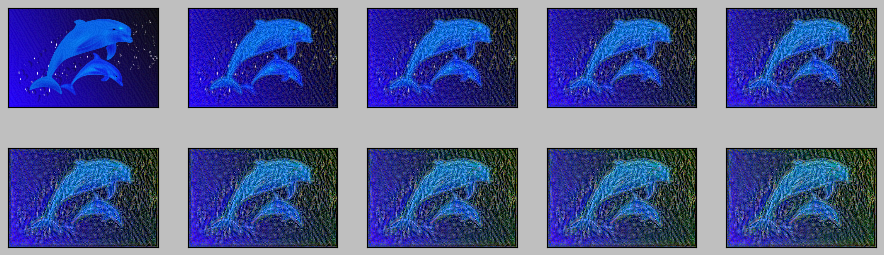

In [25]:
best_img, best_loss = run_style_transfer(content_path, style_path, num_iterations=100)

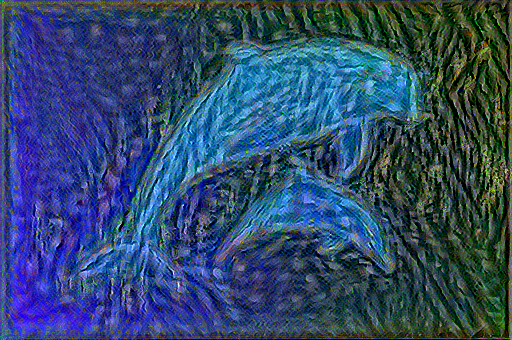

In [26]:
Image.fromarray(best_img)

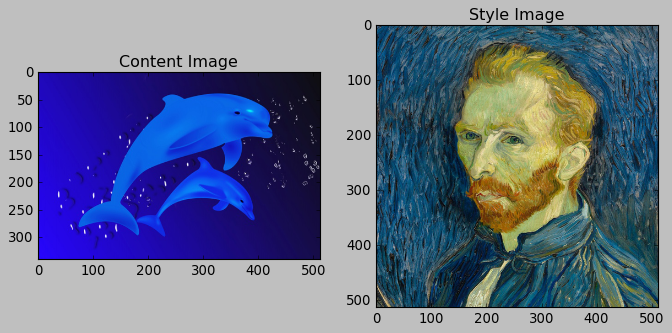

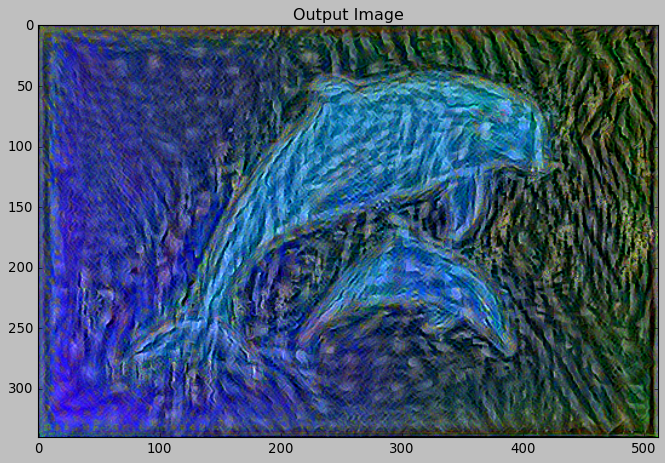

In [27]:
show_results(best_img, content_path, style_path, show_large_final=True)